# Looking at an event detected with DAS on Mount Meager

Sara Klaasen


In this notebook we will look at a single event that has been detected with Distributed Acoustic Sensing (DAS) on Mount Meager. This is a supplement to the publication 'Distributed Acoustic Sensing (DAS) and Beamforming in Volcanic and Glacial Environments: Lessons Learned'.


Several packages are needed to run this notebook, such as numpy, matplotlib, obspy and pyasdf

### Imports

First we will import all the modules we need. read_ASDF_h5 is a function to open the hdf5 data file into an obspy stream object, and specshift applies timeshift with a phase multiplication in the frequency domain.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
from func_read import read_ASDF_h5
from func_shift import specshift

### Open the data

Then we can open the file.
The file is currently placed in the same working directory, and the function read_ASDF_h5 takes the list of all files (in our case, just 1) and opens it into an obspy stream.

In [2]:
flist = sorted(glob.glob(os.getcwd() + '/*.h5'))
st = read_ASDF_h5(flist[0:1])

### Check the data


We can see what sort of data we have in the file and how many channels we have. This is a file of around 4 seconds that should contain an event. We have 380 channels in total, however, the first few channels were very close to the generator and were extremely noisy. The last few channels are not physical channels in the cable, but were "tagged on" for software reasons. We later remove those channels from the analysis and only consider channels 6 - 375.

In [3]:
print('\n stream object: \n')
print(st)

print('\n metadata: \n')
print(st[0].stats)


 stream object: 

380 Trace(s) in Stream:

MG.0000.0000.ESN | 2019-10-05T20:28:41.982500Z - 2019-10-05T20:28:45.541500Z | 1000.0 Hz, 3560 samples
...
(378 other traces)
...
MG.0379.0379.ESN | 2019-10-05T20:28:41.982500Z - 2019-10-05T20:28:45.541500Z | 1000.0 Hz, 3560 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]

 metadata: 

         network: MG
         station: 0000
        location: 0000
         channel: ESN
       starttime: 2019-10-05T20:28:41.982500Z
         endtime: 2019-10-05T20:28:45.541500Z
   sampling_rate: 1000.0
           delta: 0.001
            npts: 3560
           calib: 1.0
         _format: ASDF
            asdf: AttribDict({'format_version': '1.0.3', 'tag': 'raw_data'})


### Open GPS information


Then we open the gps positions of all channels. They have been saved as a simple numpy array with the first column being the x-coordinates, second the y-coordinates and third the z-coordinates. They are given in meters from the center of the array. We will only use the x and y coordinates in this 2D example.

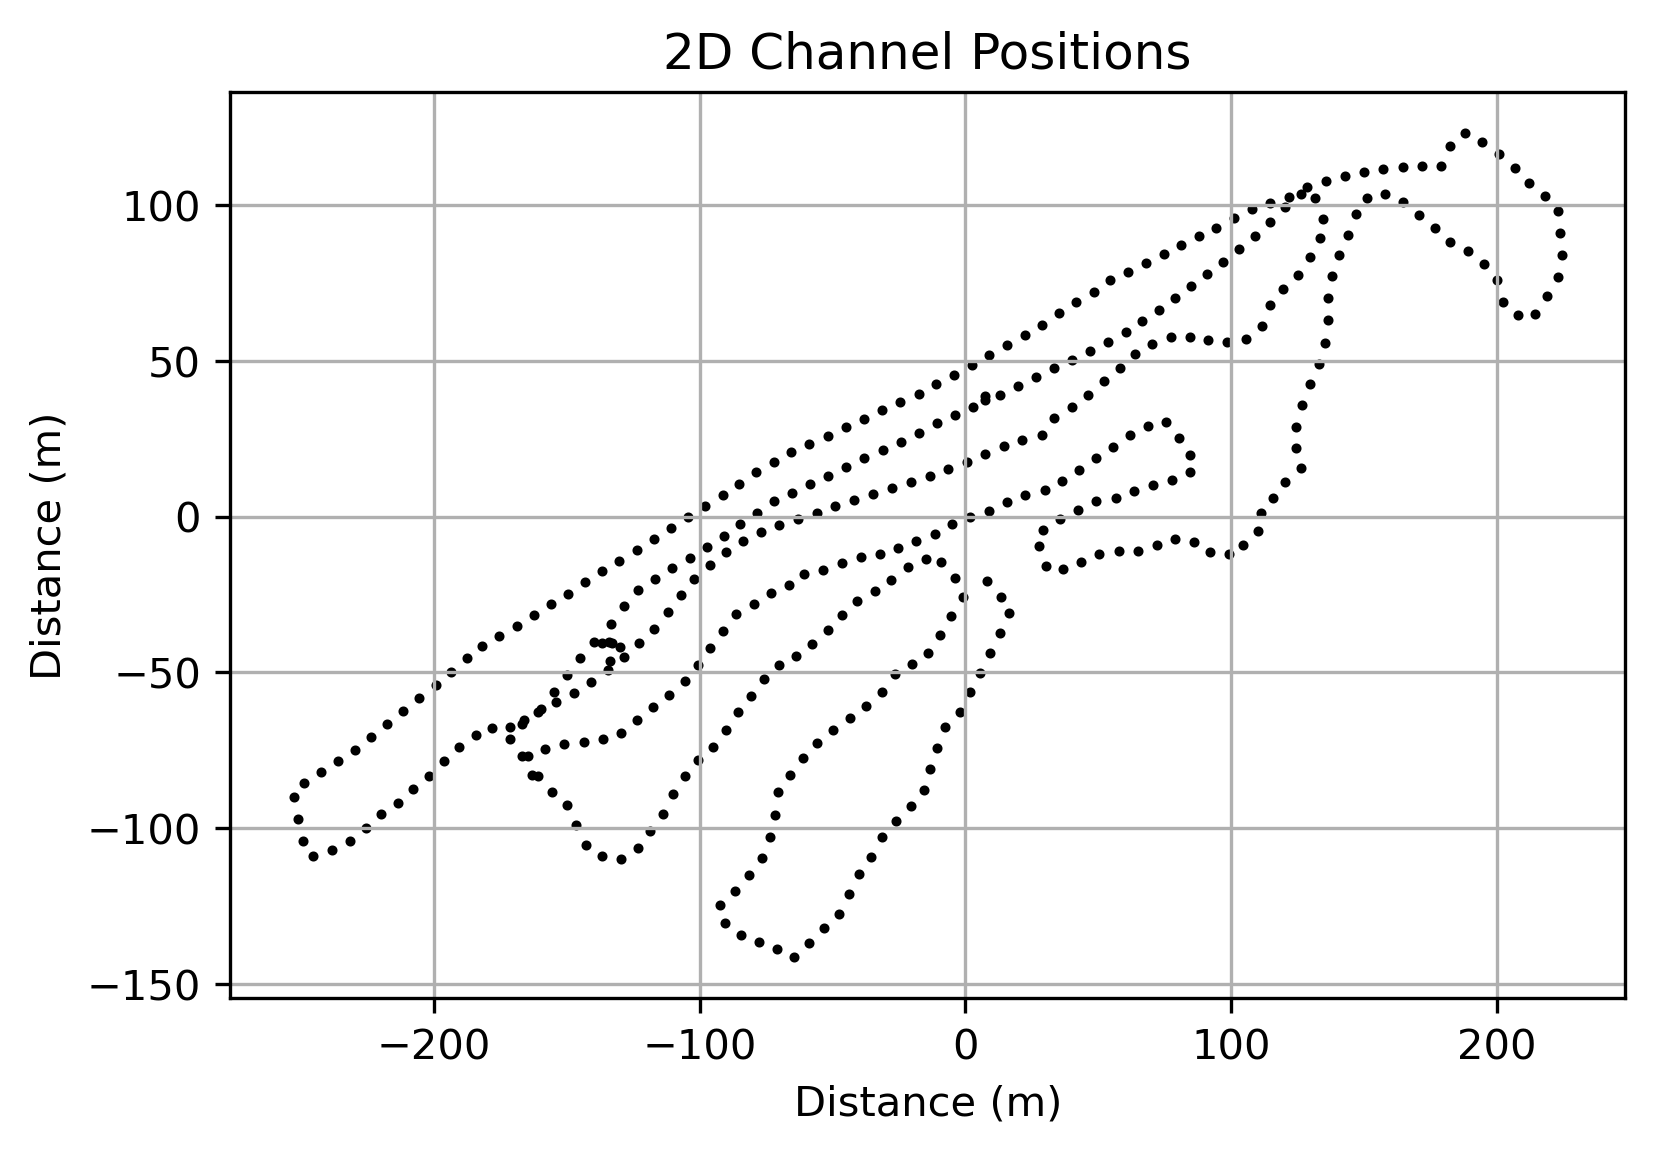

In [4]:
xyz = np.load(os.getcwd() + '/xyz.npy')

fig = plt.subplots(dpi=300)
plt.scatter(xyz[0], xyz[1], s=2, c='k')
plt.xlabel('Distance (m)')
plt.ylabel('Distance (m)')
plt.title('2D Channel Positions')
plt.grid()
plt.show()

### Visualize the raw data


Then it is time to look at the data!
We noticed that we can basically not see anything in the raw data. There are huge trends in the data that drown out all other signals. We can only see variations between channels in this plot, no variations in time.

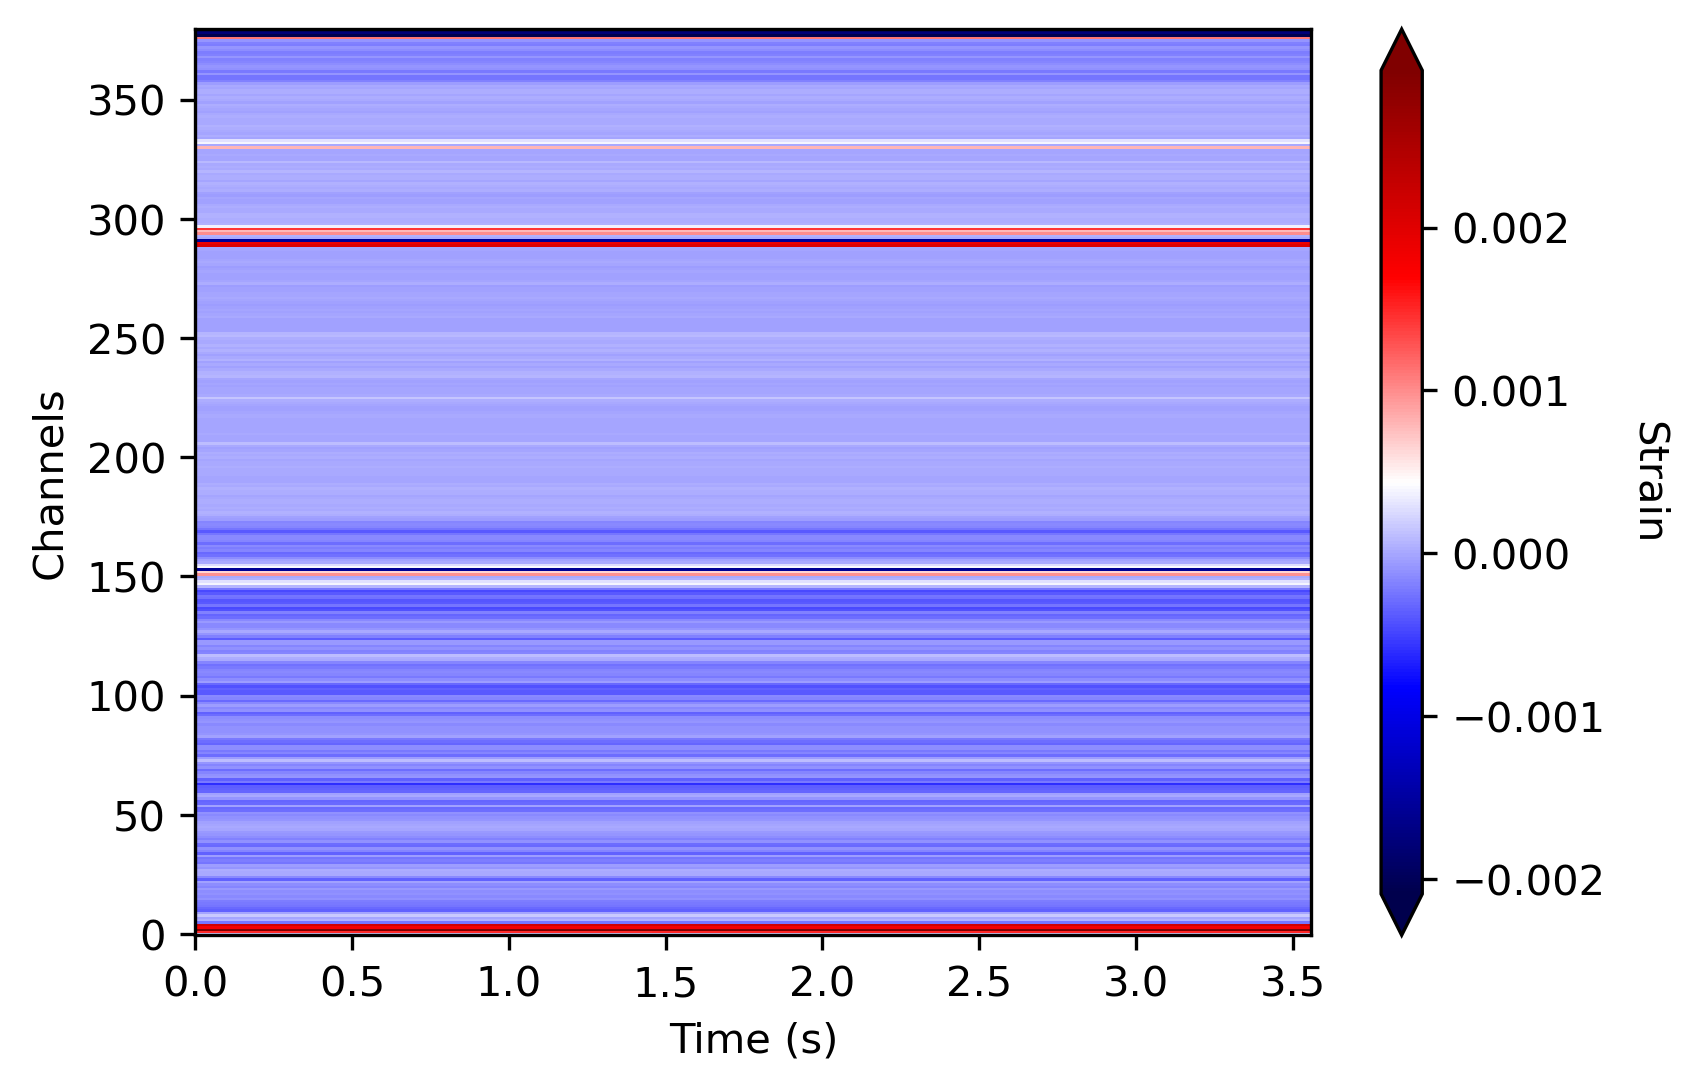

In [5]:
x = np.arange(0, len(st[0])/st[0].stats.sampling_rate, st[0].stats.delta)    
y = np.arange(0,380)

fig, ax = plt.subplots(dpi=300)
pcm = plt.pcolormesh(x, y, st, cmap='seismic', shading='nearest')
cbar = fig.colorbar(pcm, extend='both')
cbar.set_label('Strain', rotation=270, labelpad=15)
ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.ylabel('Channels')
plt.xlabel('Time (s)')
plt.show()

### Data processing



We will process the data to find the event hidden in it. The standard data processing flow we used consists of detrending the data, tapering and applying a bandpass filter. The data is also decimated to make the process computationally easier, especially the beamforming.





In [6]:
st.detrend()
st.taper(0.01)
st.filter('bandpass', freqmin=5, freqmax=45, corners=4, zerophase=True)
st.decimate(10)

380 Trace(s) in Stream:

MG.0000.0000.ESN | 2019-10-05T20:28:41.982500Z - 2019-10-05T20:28:45.532500Z | 100.0 Hz, 356 samples
...
(378 other traces)
...
MG.0379.0379.ESN | 2019-10-05T20:28:41.982500Z - 2019-10-05T20:28:45.532500Z | 100.0 Hz, 356 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]

### Visualize the processed data



Now we select all the channels that we are interested in and plot the data again. Maybe we can see something now?

To make it a bit easier to see, we clip the values at plusminus 1 nanostrain.




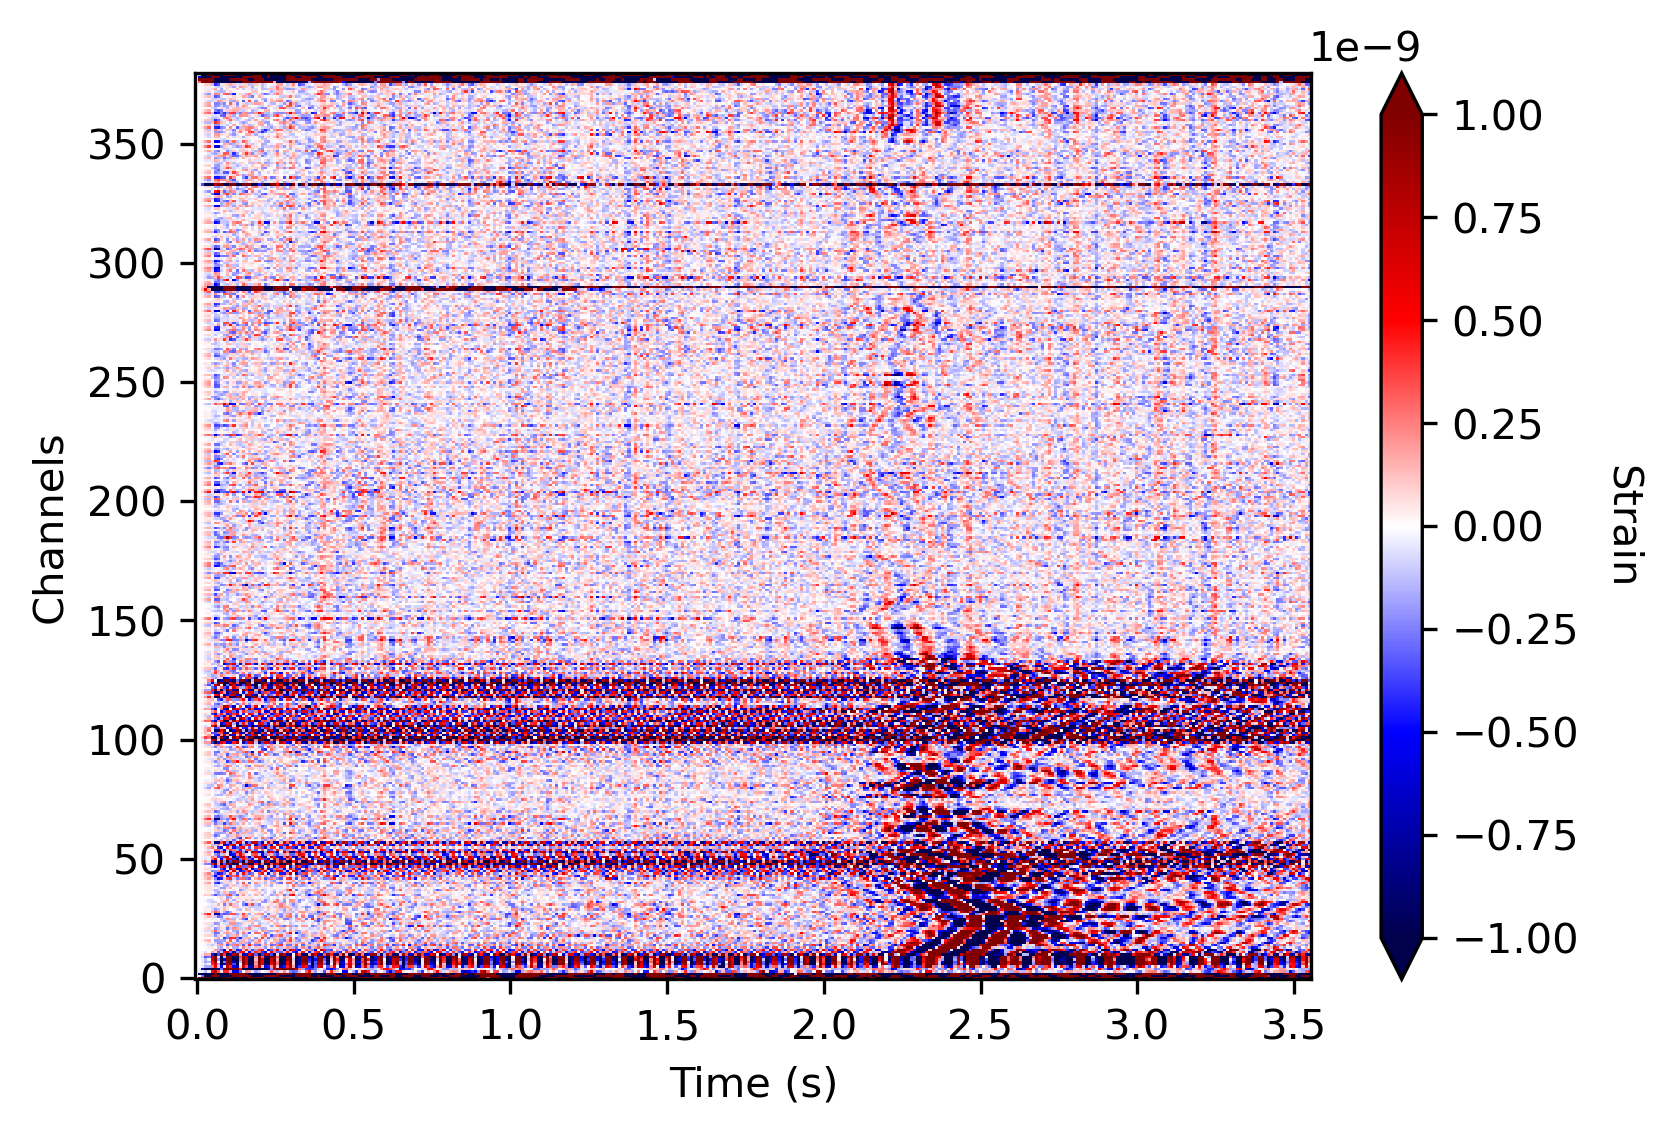

In [7]:
x = np.arange(0, len(st[0])/st[0].stats.sampling_rate, st[0].stats.delta)    

vmin = -10**-9
vmax = 10**-9

fig, ax = plt.subplots(dpi=300)
pcm = plt.pcolormesh(x, y, st, cmap='seismic', shading='nearest', vmin=vmin, vmax=vmax)
cbar = fig.colorbar(pcm, extend='both')
cbar.set_label('Strain', rotation=270, labelpad=15)
ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.ylabel('Channels')
plt.xlabel('Time (s)')
plt.show()

### Split the noise and signal windows



To calculate the Signal-to-Noise-Ratio (SNR) we need to identify a noise window as well as a signal window. The noise window is always taken right before the event. Here we read in enough data to define both windows.

These graphs show also one of the weaknesses in our results. There were too many events to pick event windows accurately and manually. This results, in this case, in an event window that is rather large and includes still a lot of noise and scattering. 

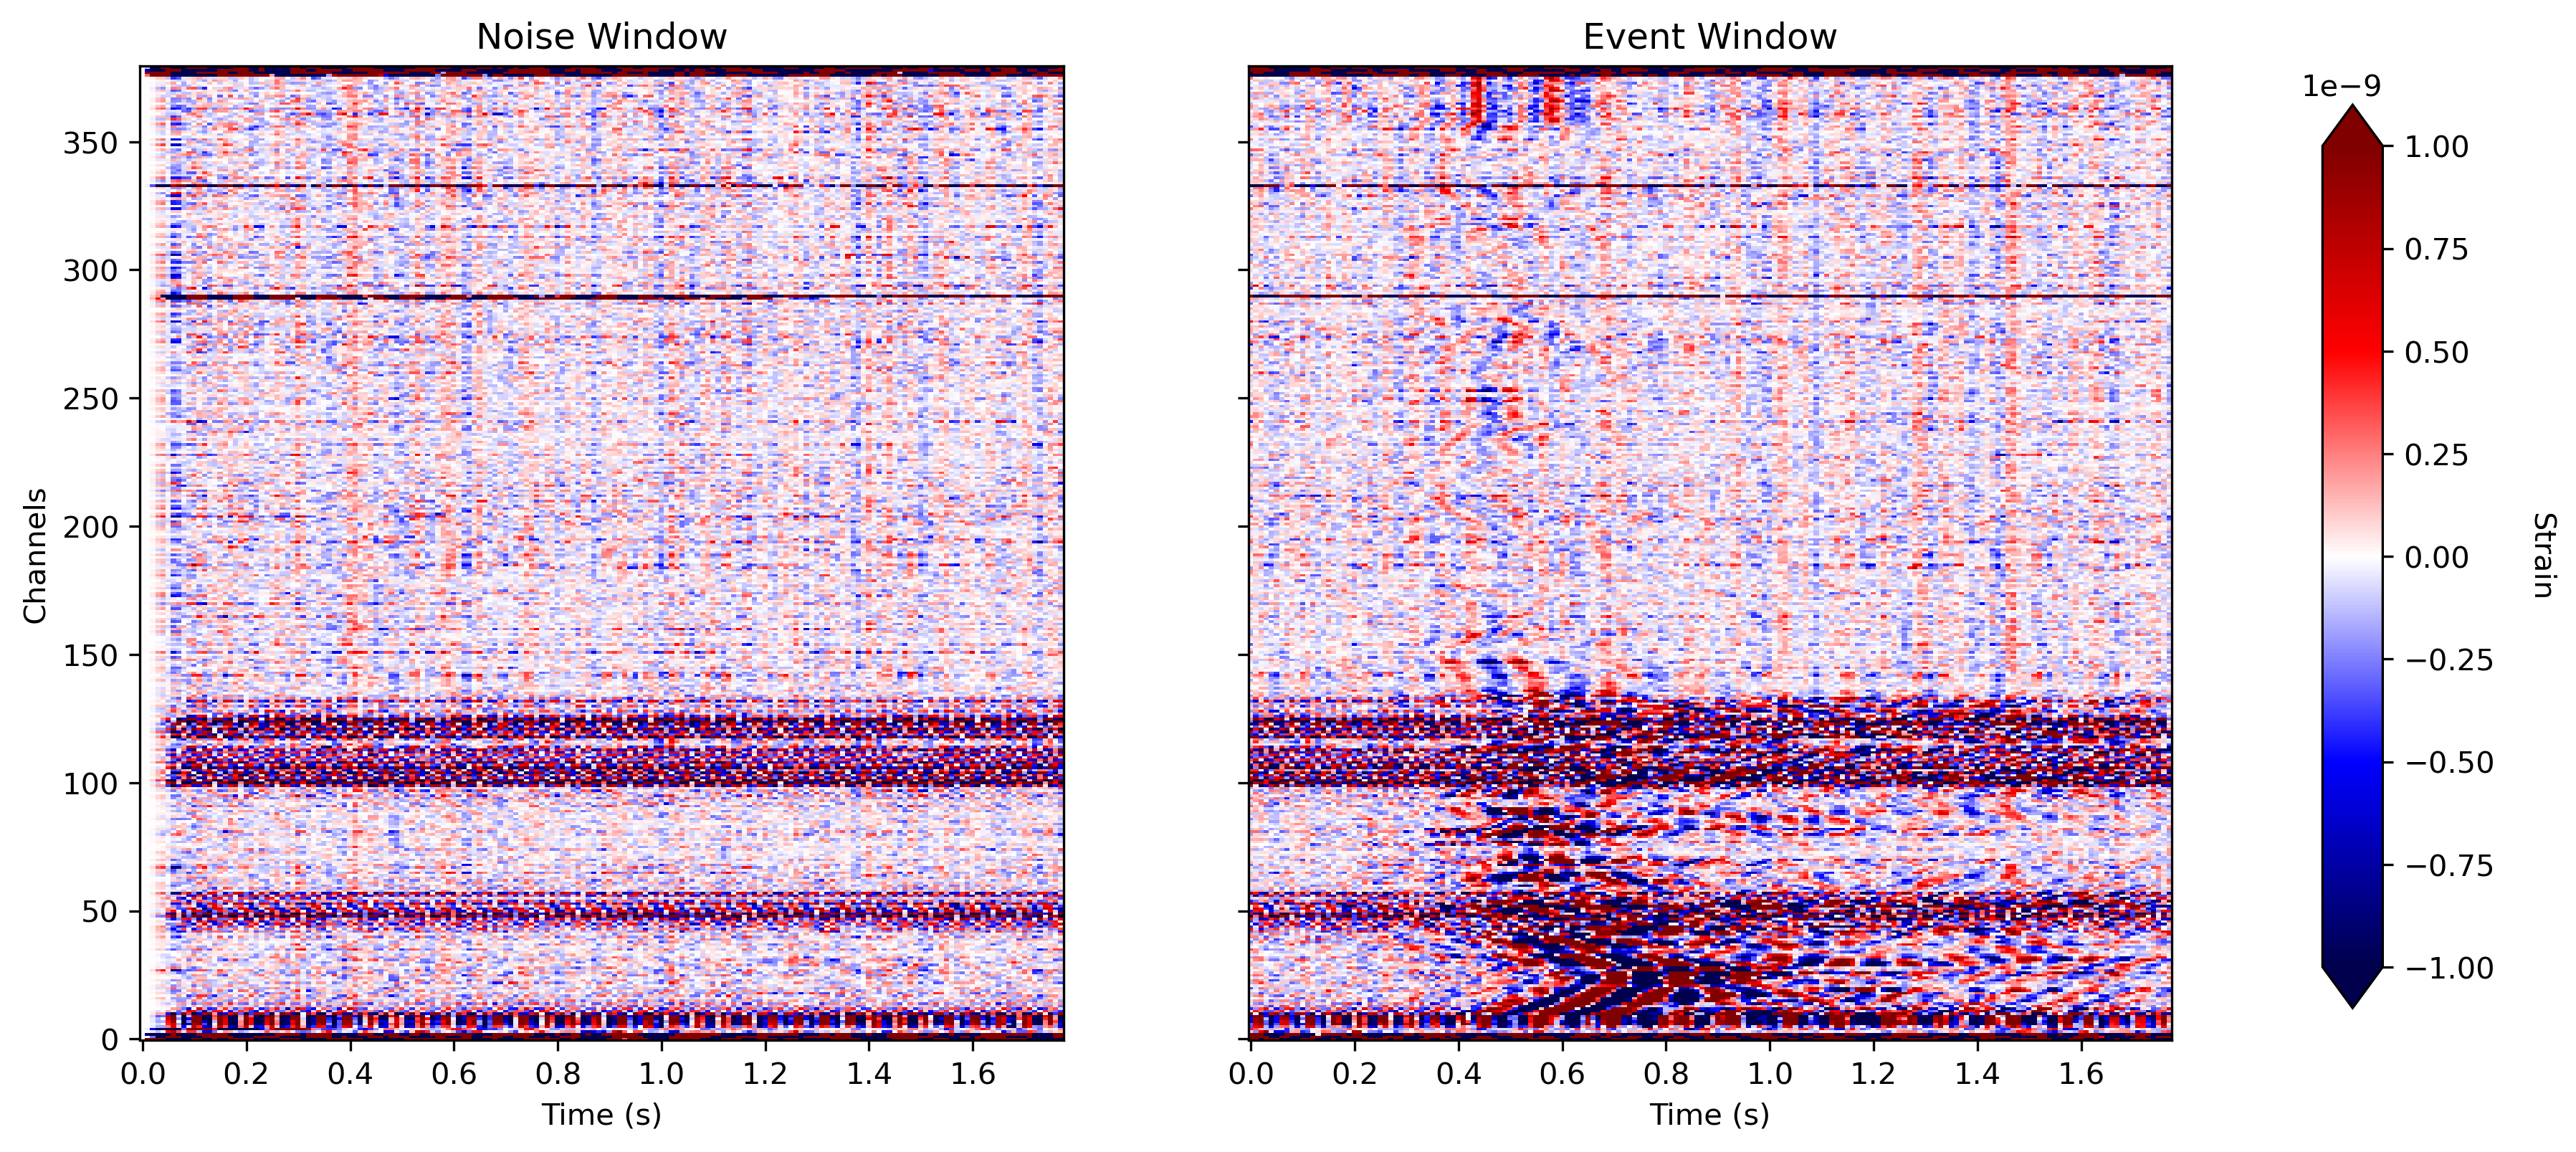

In [8]:
# create two obspy streams: noise and signal
start = st[0].stats.starttime
end = st[0].stats.endtime
mid = end - (end-start)/2

noise = st.copy()
signal = st.copy()

noise.trim(starttime=start, endtime=mid)
signal.trim(starttime=mid, endtime=end)


# figure
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14,6), sharey=True, dpi=300)

x = np.arange(0, len(noise[0])/noise[0].stats.sampling_rate, noise[0].stats.delta)    
pcm = axs[0].pcolormesh(x, y, noise, cmap='seismic', shading='nearest', vmin=vmin, vmax=vmax)
axs[0].set_ylabel('Channels')
axs[0].set_xlabel('Time (s)')
axs[0].set_title('Noise Window')

x = np.arange(0, len(signal[0])/signal[0].stats.sampling_rate, signal[0].stats.delta)    
pcm = axs[1].pcolormesh(x, y, signal, cmap='seismic', shading='nearest', vmin=vmin, vmax=vmax)
axs[1].ticklabel_format(style='sci', axis='x', scilimits=(0,0))
axs[1].set_xlabel('Time (s)')
axs[1].set_title('Event Window')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar = fig.colorbar(pcm, cax=cbar_ax, extend='both')
cbar.set_label('Strain', rotation=270, labelpad=20)

plt.show()


### Determing the SNR



We measured nearly 3000 events by using a picking algorithm that is based on the stack of traces 360-375. It is possible that some picked events are not visible in the rest of the array. We examine the SNR's of events to ensure that they are visible in most of the array.

Here we determine the SNR of each channel, using both the noise and the signal window. We can see that the SNR tends to be higher on the ridge, where the signal continues for longer.

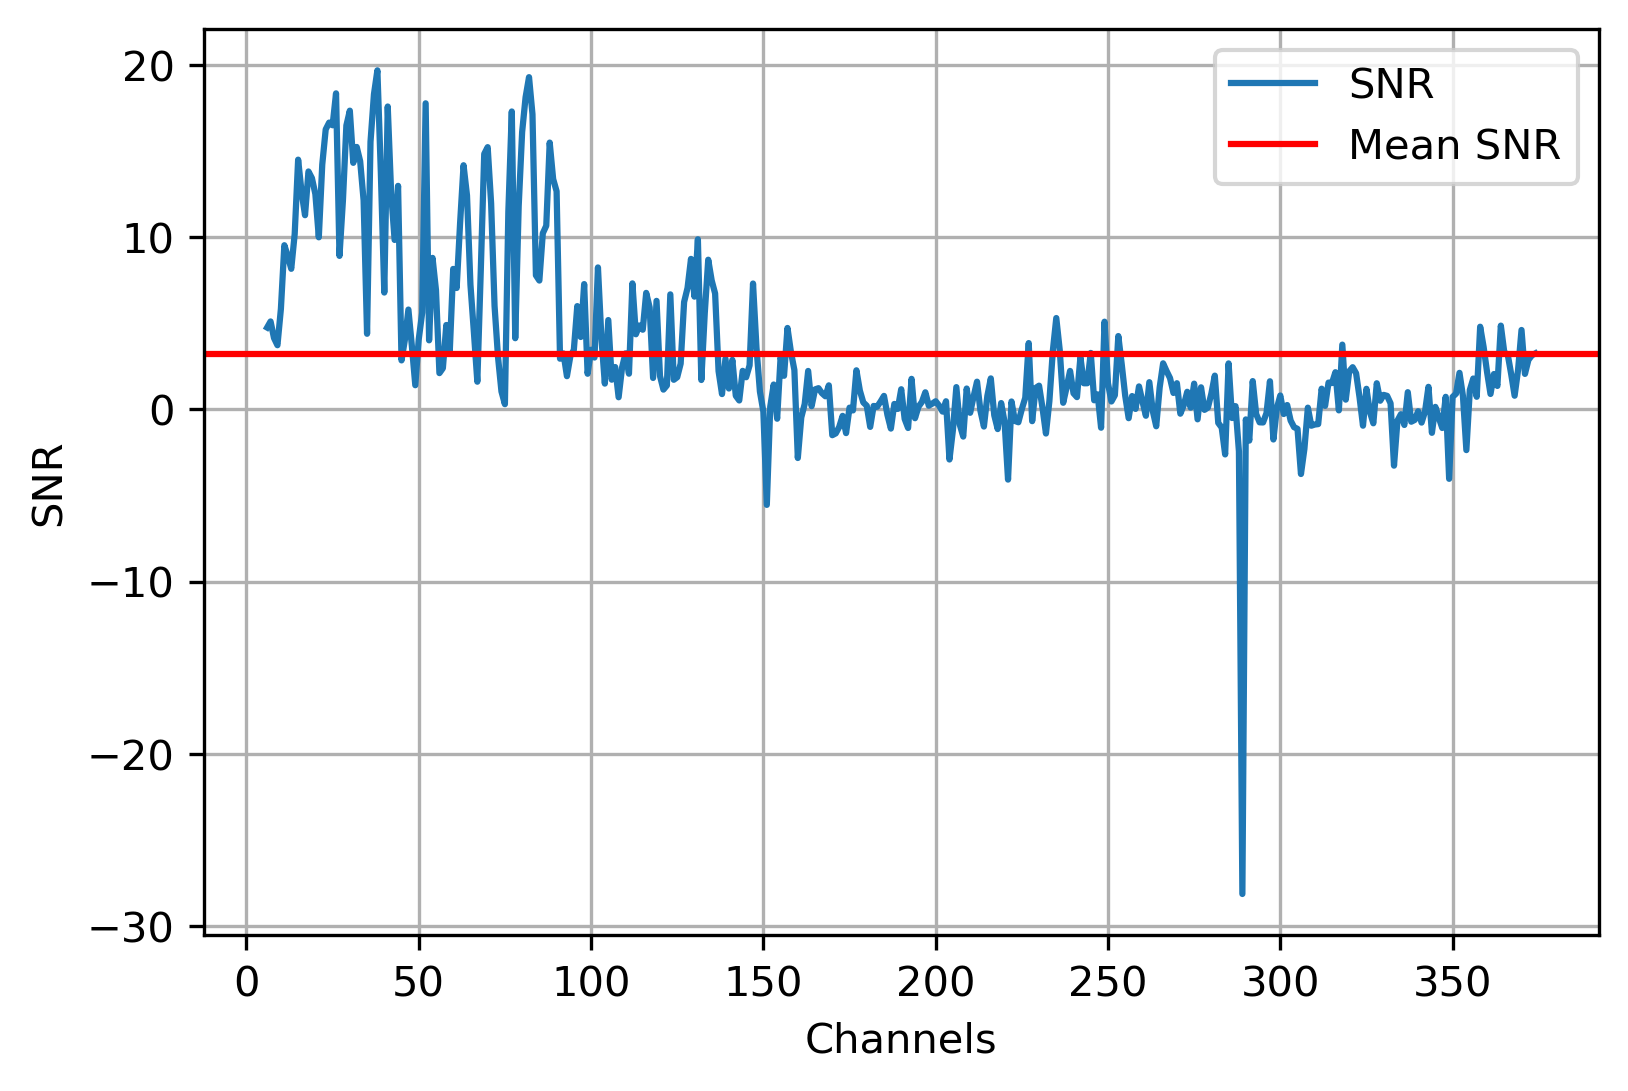

In [9]:
# function to calculate power of time series
def power(x, fs, dbscale=True):
    y = 0
    for i in x:
        y = y + i**2
    if dbscale:
        y = 10 * np.log10(y)
    return y

fs = st[0].stats.sampling_rate
dt = 1/fs

# convert obspy streams into numpy arrays
s = np.zeros((len(signal), len(signal[0])))
n = np.zeros((len(noise), len(noise[0])))
for i in range(len(signal)):
    s[i] = signal[i].data
    n[i] = noise[i].data
    
# discard first and last few channels
s = s[6:375]
n = n[6:375]

# calculate SNR
pow_sig = np.zeros(len(s))
pow_noi = np.zeros(len(n))

for i in range(len(s)):
    pow_sig[i] = power(s[i], fs)
    pow_noi[i] = power(n[i], fs)
    
SNR = pow_sig - pow_noi
mean_SNR = np.mean(SNR)
norm_SNR = SNR/np.max(SNR)

y = np.arange(6, 375)

# figure
fig = plt.subplots(dpi=300)
plt.plot(y, SNR, label='SNR')
plt.axhline(mean_SNR, color='r', label='Mean SNR')
plt.xlabel('Channels')
plt.ylabel('SNR')
plt.legend()
plt.grid()
plt.show()

## Beamforming



Then it is time for beamforming!
First we define the grid of slowness components to do the grid search over. Then we iterate over all slowness components, shift the data accordingly and use averaged cross-correlation coefficients to determine the beampower of the iteration.
To improve the beamforming results, we take the SNR of each individual channel into account by excluding channels with a low SNR

In [10]:
# slowness grid components
sl = 3/1000
nux = 100
nuy = 100
ux = np.linspace(-sl, sl, nux)
uy = np.linspace(-sl, sl, nuy)
dux = ux[1]-ux[0]
duy = uy[1]-uy[0]

# P will be our final beamform "Power"
P=np.zeros([nux,nuy])

data = s.T

thresh = 0.5

counter_grid = 0
print("starting gridpoints: {0}".format(nux*nuy))
for ix in range(0,nux):
    for iy in range(0,nuy):
        counter_grid+=1
        if(counter_grid % 1000 == 0):
            print(counter_grid)

        # dist[km]*slowness[s/m] = time[s]
        timeshifts = xyz[0]*ux[ix] + xyz[1]*uy[iy]

        # Apply the timeshift
        dshift = specshift(data,-timeshifts/dt) 
        dshift = dshift.T
        
        # Exclude low-quality channels
        if thresh != 0:
            c=0    
            for chan in range(len(s)):
                if norm_SNR[chan] < thresh:
                    c=c+1
                    dshift[chan] = dshift[chan] * 0

        # Rxx will be a matrix of each waveform correlated with each other waveform
        Rxx = np.corrcoef(dshift)
        np.fill_diagonal(Rxx,0) # Exclude autocorrelations

        if thresh != 0:
            idx_nans = np.isnan(Rxx)
            Rxx[idx_nans] = 0
            nonzero = np.count_nonzero(Rxx)
            P[ix, iy] = np.sum(Rxx)/((len(st)-c)**2)
        else:
            P[ix, iy] = np.sum(Rxx)/np.size(Rxx)

starting gridpoints: 10000


/Users/saraklaasen/miniconda3/envs/env_obspy/lib/python3.8/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/saraklaasen/miniconda3/envs/env_obspy/lib/python3.8/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


1000
2000
3000
4000
5000
6000
7000
8000
9000
10000


### Visualize the beamforming results


Finally, we can see that the beamforming result of this event converges nicely at one location.

The white circle shows the slowness components where the wave travels with 1 km/s.

<ipython-input-11-a20dd87667c4>:10: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  i = plt.pcolormesh(ux-dux/2,uy-duy/2,np.real(P.T), cmap=cmap, rasterized=True)


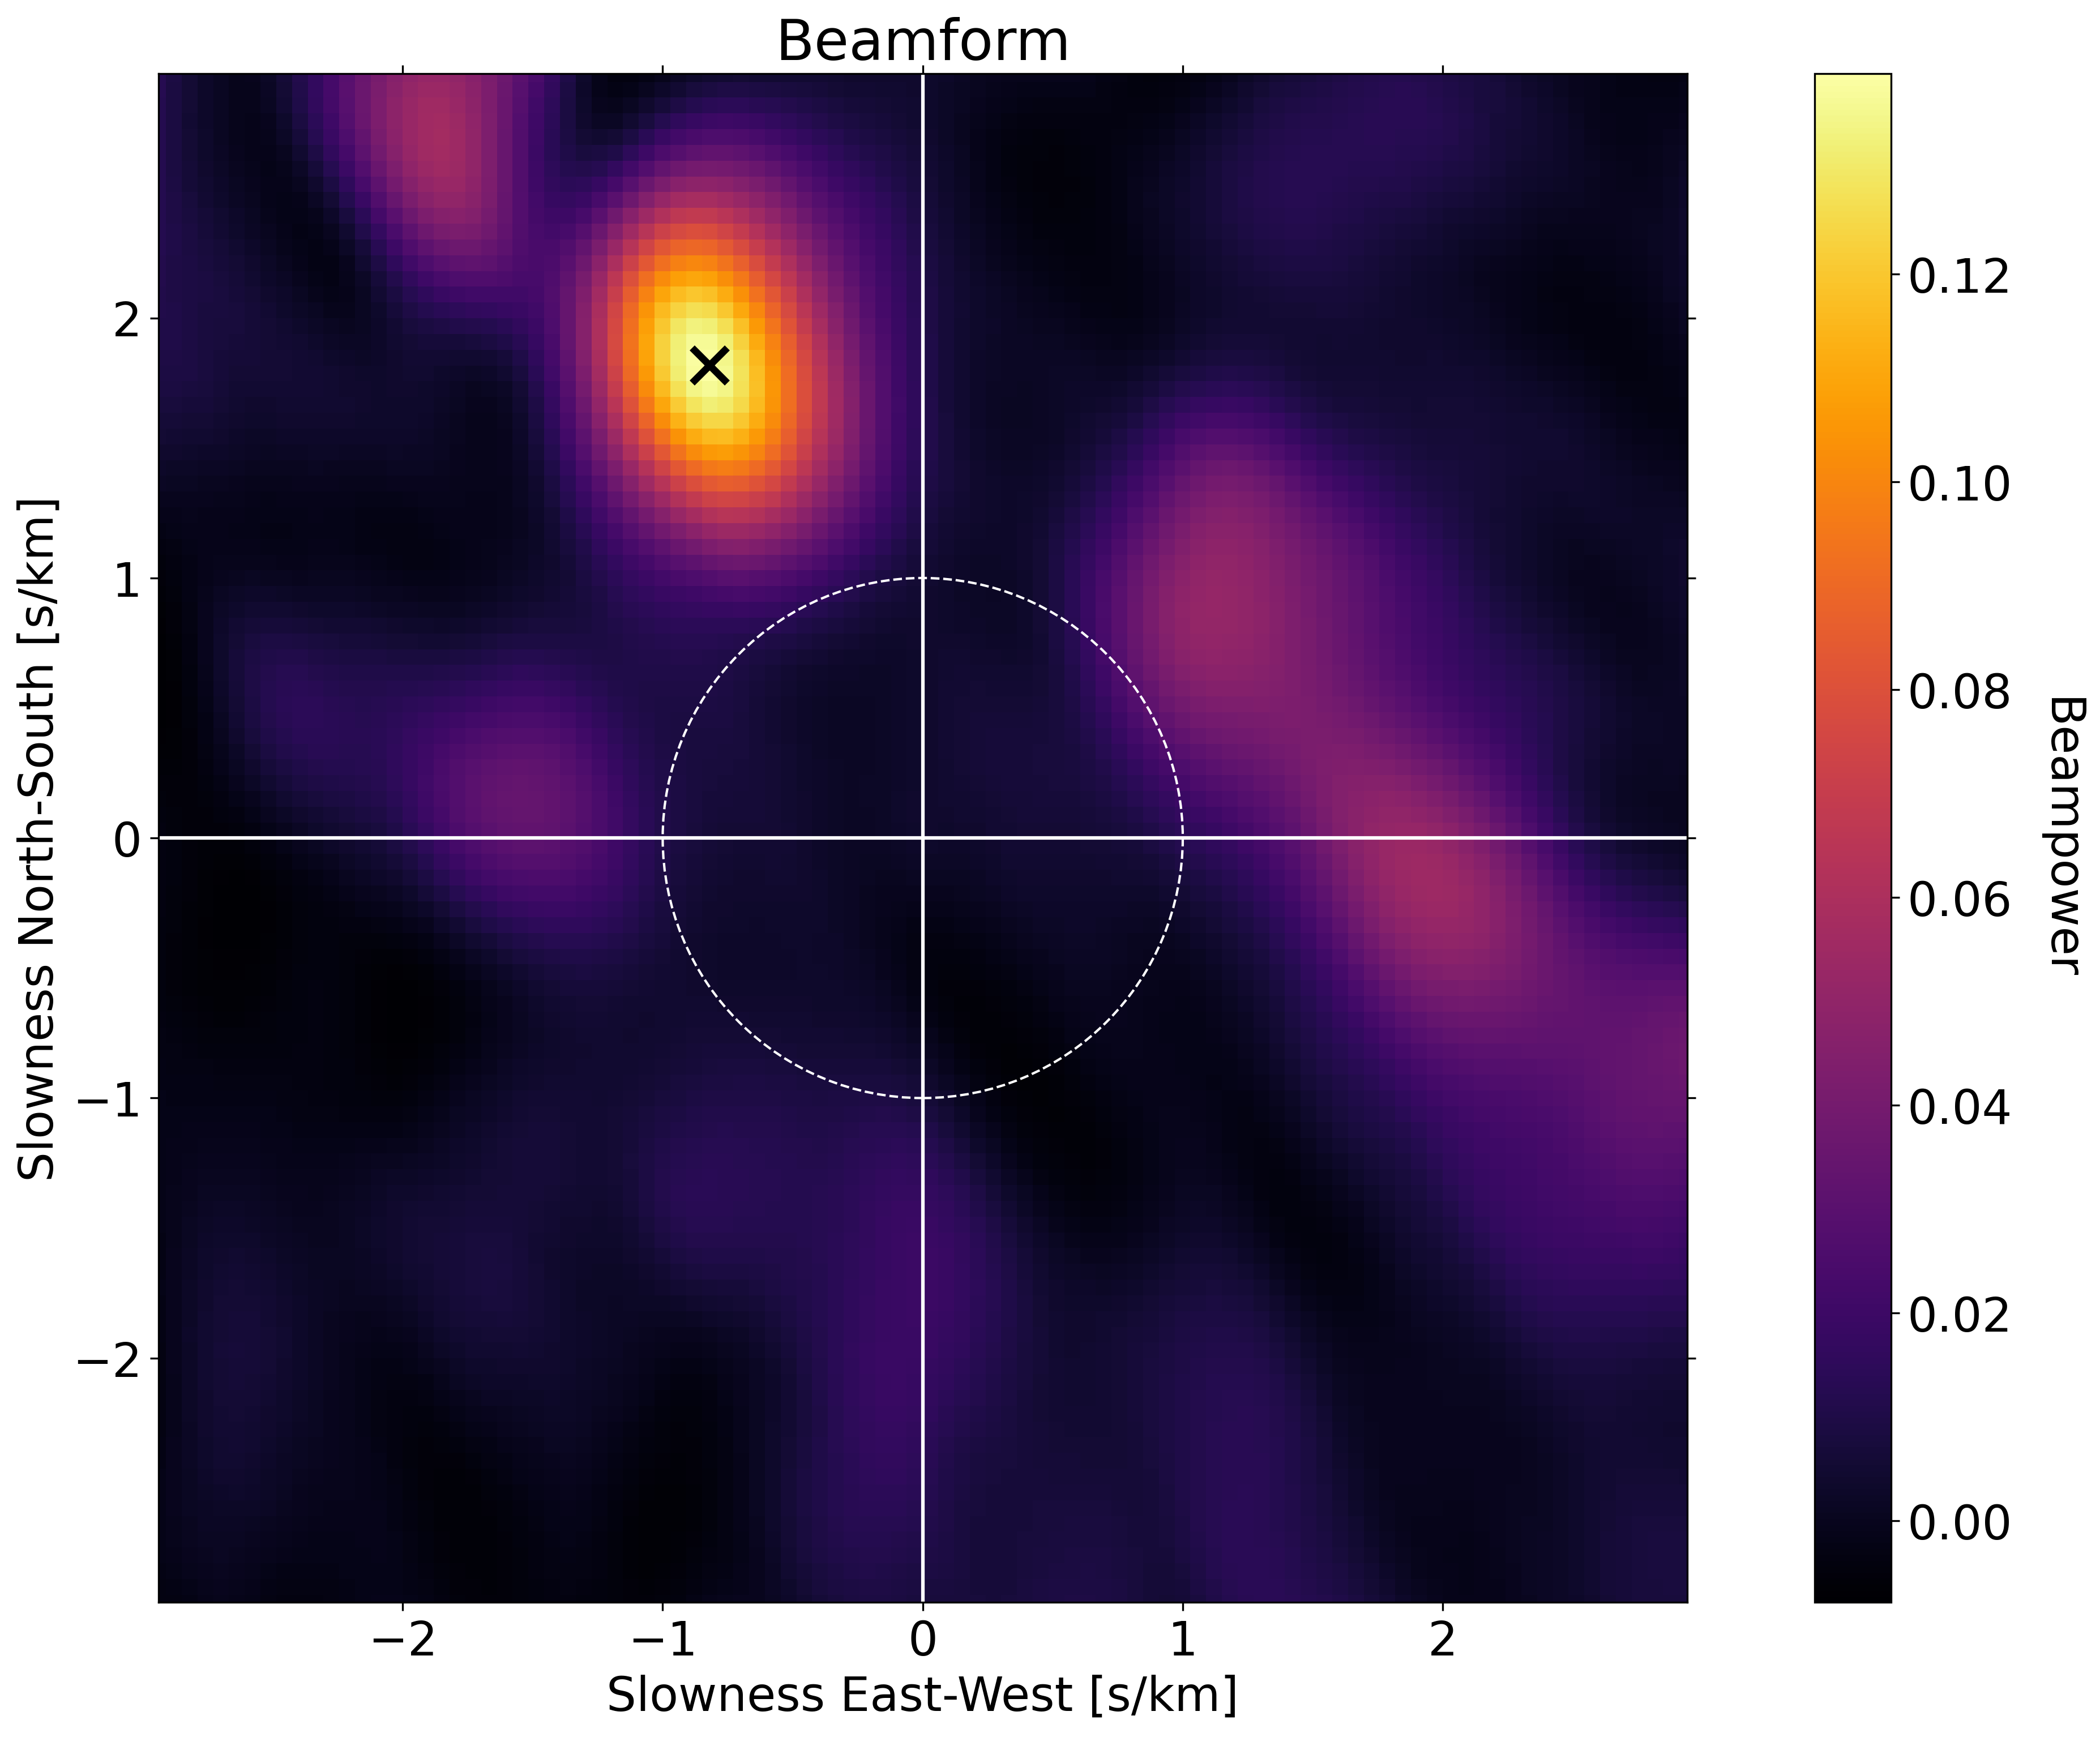

In [11]:
import matplotlib as mpl

mpl.rc('font', **{'size':20})
def plot_beam(P, title="Beamform",save=0,savename='none',scale=None):
    idxr, idxc = np.where(P==np.max(P))
    
    fig = plt.figure(figsize=(15,15), dpi=300)
    ax = fig.add_axes([0.1,0.1,0.6,0.6])  #x0,y0,dx,dy
    cmap = plt.get_cmap('inferno')
    i = plt.pcolormesh(ux-dux/2,uy-duy/2,np.real(P.T), cmap=cmap, rasterized=True)
    cmax=np.max(P)
    if(scale=='sym'):
        cmin=-cmax
    else:
        cmin=np.min(P)
    plt.clim(cmin,cmax)
    plt.axis('equal')
    plt.axis('tight')
    plt.xlim(min(ux)+dux,max(ux)-dux)
    plt.ylim(min(uy)+duy,max(uy)-duy)
    plt.xlabel('Slowness East-West [s/km]')
    plt.ylabel('Slowness North-South [s/km]')
    ax.tick_params(top=True,right=True)
    plt.plot([np.min(ux), np.max(ux)],[0,0],'w')
    plt.plot([0,0],[np.min(uy), np.max(uy)],'w')
    
    # Plot a circle at a relative velocity
    Rvel=1 #km/s
    circle=plt.Circle((0,0), radius=1/Rvel, fill=False, edgecolor='w', linestyle='--')
    ax.add_patch(circle)
    
    plt.plot((ux-dux/20)[idxr],(uy-duy/2)[idxc], 'x', markersize=15, mew=3, color='k')
      
    
    plt.title(title)
    colorbar_ax = fig.add_axes([0.75, 0.1, 0.03, 0.6])  #x0,y0,dx,dy
    cbar = fig.colorbar(i, cax=colorbar_ax)
    cbar.set_label('Beampower', rotation=270, labelpad=30)
    if(save==1):
        plt.savefig(savename, bbox_inches='tight', dpi=300)
    plt.show()

# redefine slowness grid in km for plotting it
sl = 3
nux = 100
nuy = 100
ux = np.linspace(-sl, sl, nux)
uy = np.linspace(-sl, sl, nuy)
dux = ux[1]-ux[0]
duy = uy[1]-uy[0]
    
plot_beam(P)